In [1]:
from functools import partial
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import diffrax as dfx
import optax
import numpy as np 
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConsumer
import tensorflow_probability.substrates.jax.distributions as tfd

from configs import make_dirs
from configs.shear import shear
from data.shear import get_shear_experiment, simulator 
from sbiax.utils import make_df
from sbiax.ndes import Ensemble, MAF, CNF, Scaler
from sbiax.train import train_ensemble
from sbiax.compression.nn import fit_nn
from sbiax.inference import nuts_sample

Here we run density-estimation SBI on a datavector made up of cosmic shear two-point functions.

Our `config` object contains all the properties of the models, training and sampling. You could use all its properties without the `config` object itself.

In [2]:
config = shear()

key = jr.key(config.seed)
key, model_key, nn_key, train_key, sample_key, data_key = jr.split(key, 6)

In [3]:
results_dir = "results/{}/{}/{}/".format(
    config.sbi_type, config.exp_name, config.seed
) 
make_dirs(results_dir)

RESULTS_DIR:
 results/nle/shear/0/


Here we load some typical data and objects associated with an inference, which you would need yourself. 

In [4]:
data_dir = "../data/shear/"

(
    alpha,                  # True parameters
    parameter_names,        # Parameter names
    mu,                     # Model expectation
    covariance,             # Data covariance
    precision,              # Inverse data covariance
    dmu,                    # Theory derivatives
    F,                      # Fisher information
    Finv,                   # Inverse Fisher information 
    lower,                  # Lower prior bounds
    upper                   # Upper prior bounds
) = get_shear_experiment(data_dir)

Here we sample a set of $n_s$ simulations from the true data likelihood $\mathcal{G}[\hat{\xi}|\xi[\pi], \Sigma]$ for training the neural network compression models and then training the flows on these compressed simulations.

In [5]:
key_prior, key_simulate = jr.split(data_key)

# Data-generating likelihood 
_simulator = partial(
    simulator, 
    alpha=alpha, 
    mu=mu, 
    derivatives=dmu,
    covariance=covariance
)

# Parameter prior 
parameter_prior = tfd.Blockwise(
    [
        tfd.Uniform(low=lower[p], high=upper[p]) 
        for p in range(alpha.size)
    ]
)
Y = parameter_prior.sample((config.n_s,), seed=key_prior)

# Simulate training set
keys = jr.split(key_simulate, config.n_s)
D = jax.vmap(_simulator)(keys, Y)

It is common to reduce the dimensionality of the datavector by using a compression - we fit a neural network trained with an MSE loss.

You are free to use any neural network created with an `eqx.Module`.

In [6]:
net_key, net_train_key = jr.split(nn_key)

net = eqx.nn.MLP(
    D.shape[-1], 
    Y.shape[-1], 
    width_size=32, 
    depth=2, 
    activation=jax.nn.tanh,
    key=net_key
)

opt = optax.adamw(1e-3)

preprocess_fn = lambda d: (d - D.mean(axis=0)) / D.std(axis=0)

model, losses = fit_nn(
    net_train_key, 
    net, 
    train_data=[preprocess_fn(D), Y], 
    opt=opt, 
    n_batch=512, 
    patience=1000
)

X = jax.vmap(model)(preprocess_fn(D))

Training NN:   0%|          | 0/10000 [00:00<?, ?it/s]

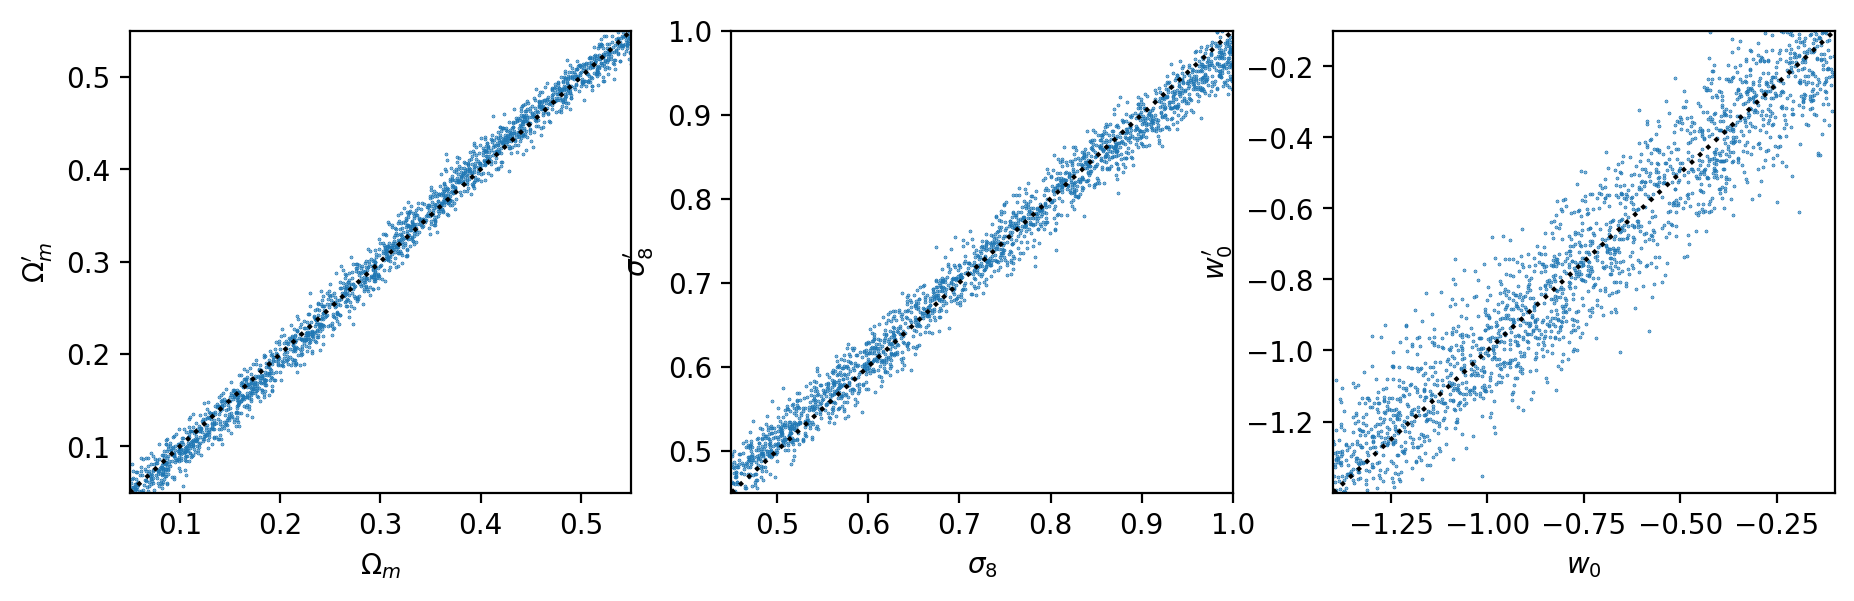

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(11., 3.), dpi=200)
for p, ax in enumerate(axs.ravel()):
    ax.axline((0, 0), slope=1, color="k", linestyle=":")
    ax.scatter(Y[:, p], X[:, p], s=0.1)
    ax.set_xlabel(parameter_names[p])
    ax.set_ylabel(parameter_names[p][:-1] + "'$")
    ax.set_xlim(lower[p], upper[p])
    ax.set_ylim(lower[p], upper[p])
plt.show()

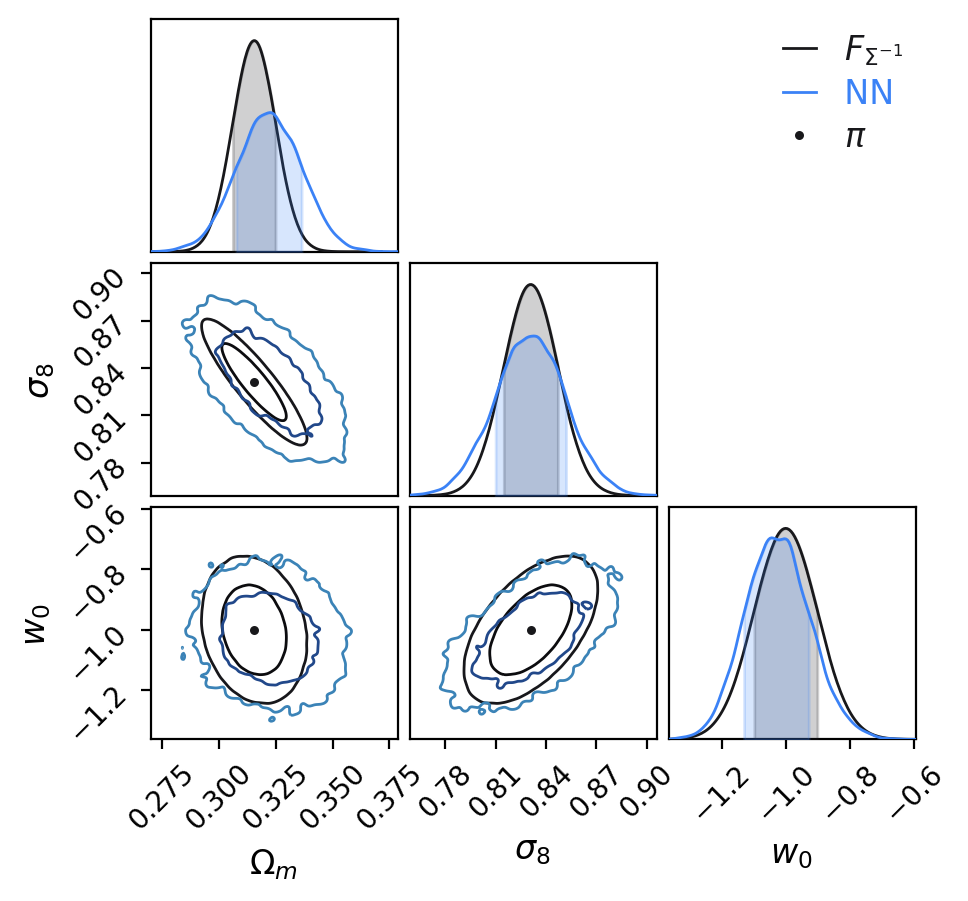

In [8]:
c = ChainConsumer()

c.add_chain(
    Chain.from_covariance(
        alpha,
        Finv,
        columns=parameter_names,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        shade_alpha=0.
    )
)

D0 = jr.multivariate_normal(key, mu, covariance, (10_000,))
X0 = jax.vmap(model)(preprocess_fn(D0))

c.add_chain(
    Chain(
        samples=make_df(X0, jnp.ones((len(X0),)), parameter_names), 
        name="NN",
        color="b", 
        shade_alpha=0.
    )
)

c.add_marker(
    location=dict(zip(parameter_names, np.asarray(alpha))), name=r"$\pi$", color="k"
)

fig = c.plotter.plot()
fig.set_dpi(200)
fig.set_figheight(4.5)
fig.set_figwidth(4.5)
plt.show()

Next we build the density-estimating normalising flows.

We'll use two continuous normalising flows (CNFs, Garthwohl++2018) and put them in an `Ensemble`. This object can pass through `jit` boundaries and has its own `log_prob` functions.

In [9]:
model_keys = jr.split(model_key, 1)

scaler = Scaler(X, Y, use_scaling=config.model.use_scaling)

solver = getattr(dfx, config.model.solver)()

ndes = [
    CNF(
        event_dim=alpha.size, 
        context_dim=alpha.size, 
        width_size=config.model.width_size,
        depth=config.model.depth, 
        solver=solver,
        activation=config.model.activation,
        dt=config.model.dt, 
        t1=config.model.t1, 
        dropout_rate=config.model.dropout_rate,
        exact_log_prob=config.model.exact_log_prob,
        scaler=scaler,
        key=key
    )
    for key in model_keys
]

ensemble = Ensemble(ndes, sbi_type=config.sbi_type)

Now we fit the flow ensemble to the compressed simulations $\{ (\hat{\pi}, \pi)_0, ..., (\hat{\pi}, \pi)_N\}$

In [10]:
opt = getattr(optax, config.opt)(config.lr)

ensemble, stats = train_ensemble(
    train_key, 
    ensemble,
    train_mode=config.sbi_type,
    train_data=[X, Y], 
    opt=opt,
    n_batch=config.n_batch,
    patience=config.patience,
    n_epochs=config.n_epochs,
    results_dir=results_dir
)

NDE has n_params=51.


Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Weights: [1.]


Now we sample a measurement to condition our posterior with. This noisy datavector is from the same likelihood above, and we pass it to the `Ensemble` likelihood function.

This `log_prob` function is sampled via the `nuts_sample` function below.

In [11]:
# Get a noisy datavector with different alpha parameters
key_data, key_state, key_sample = jr.split(sample_key, 3)

# Generates datavector d ~ G[d|xi[pi], Sigma]
datavector = jr.multivariate_normal(key_data, mu, covariance)

# Neural network summary
X_ = model(preprocess_fn(datavector))

ensemble = eqx.nn.inference_mode(ensemble)

log_prob_fn = ensemble.ensemble_log_prob_fn(X_, parameter_prior)

In [12]:
n_chains = 1

samples, samples_log_prob = nuts_sample(
    key_sample, log_prob_fn, n_chains=n_chains, prior=parameter_prior
)

Finally we plot the posterior. Nothing fancy here, we simply use `chainconsumer` to plot our chains. 

The `Ensemble` likelihood chain is compared to a Fisher forecast - which is the analytic solution to this inference problem given the Gaussian errors and linear model.

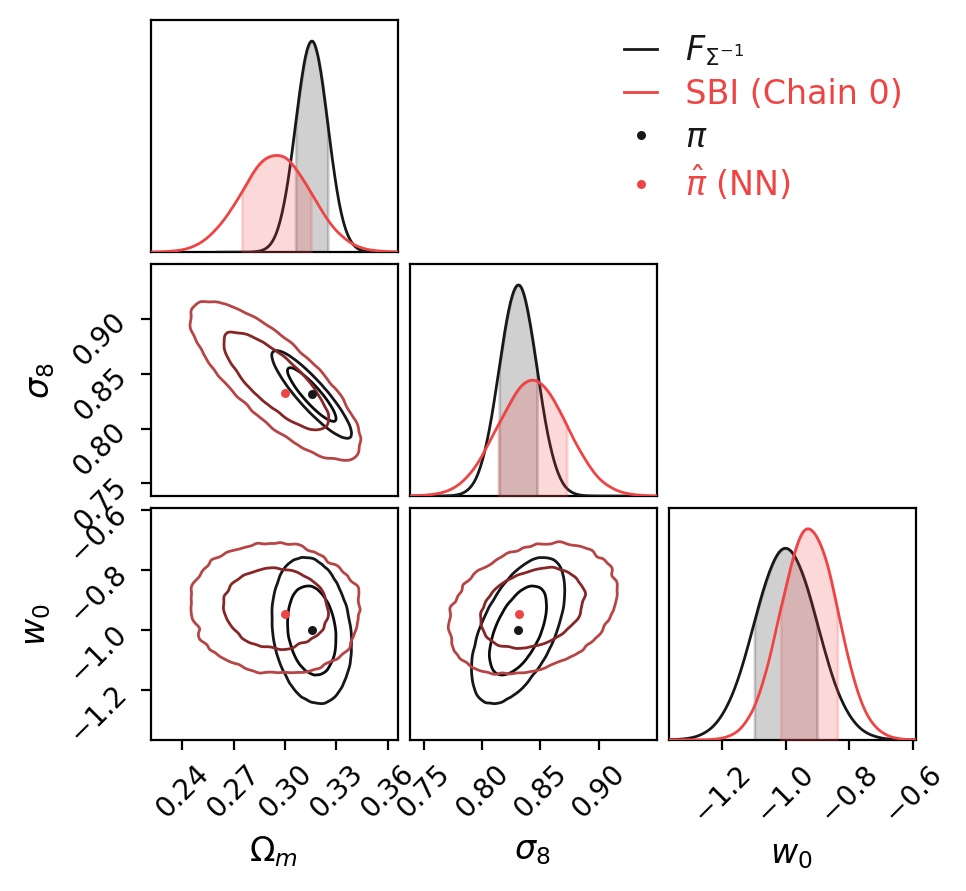

In [13]:
c = ChainConsumer()

c.add_chain(
    Chain.from_covariance(
        alpha,
        Finv,
        columns=parameter_names,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        shade_alpha=0.
    )
)

for n in range(n_chains):
    c.add_chain(
        Chain(
            samples=make_df(samples[n], jnp.ones((len(samples[n]),)), parameter_names), 
            name="SBI (Chain {})".format(n),
            color="r", 
            shade_alpha=0.
        )
    )

c.add_marker(
    location=dict(zip(parameter_names, np.asarray(alpha))), name=r"$\pi$", color="k"
)
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(X_))), name=r"$\hat{\pi}$ (NN)", color="r"
)

fig = c.plotter.plot()
fig.set_dpi(200)
fig.set_figheight(4.5)
fig.set_figwidth(4.5)
plt.show()

We can also sample the posterior of one of the flows at a time.

This is done by using the `nde_log_prob_fn` of the `Ensemble` module.

In [14]:
# Get a noisy datavector with different alpha parameters
key_data, key_state, key_sample = jr.split(sample_key, 3)

# Generates datavector d ~ G[d|xi[pi], Sigma]
datavector = jr.multivariate_normal(key_data, mu, covariance)

# Linear summary
X_ = model(preprocess_fn(datavector))

ensemble = eqx.nn.inference_mode(ensemble)

In [15]:
n_chains = 1

posteriors = []
for nde in ensemble.ndes:
    # Optionally set parameter prior for whole ensemble vs. here?
    log_prob_fn = ensemble.nde_log_prob_fn(nde, X_, parameter_prior)

    nde_posterior = nuts_sample(
        key_sample, log_prob_fn, n_chains=n_chains, prior=parameter_prior
    )
    posteriors.append(nde_posterior)

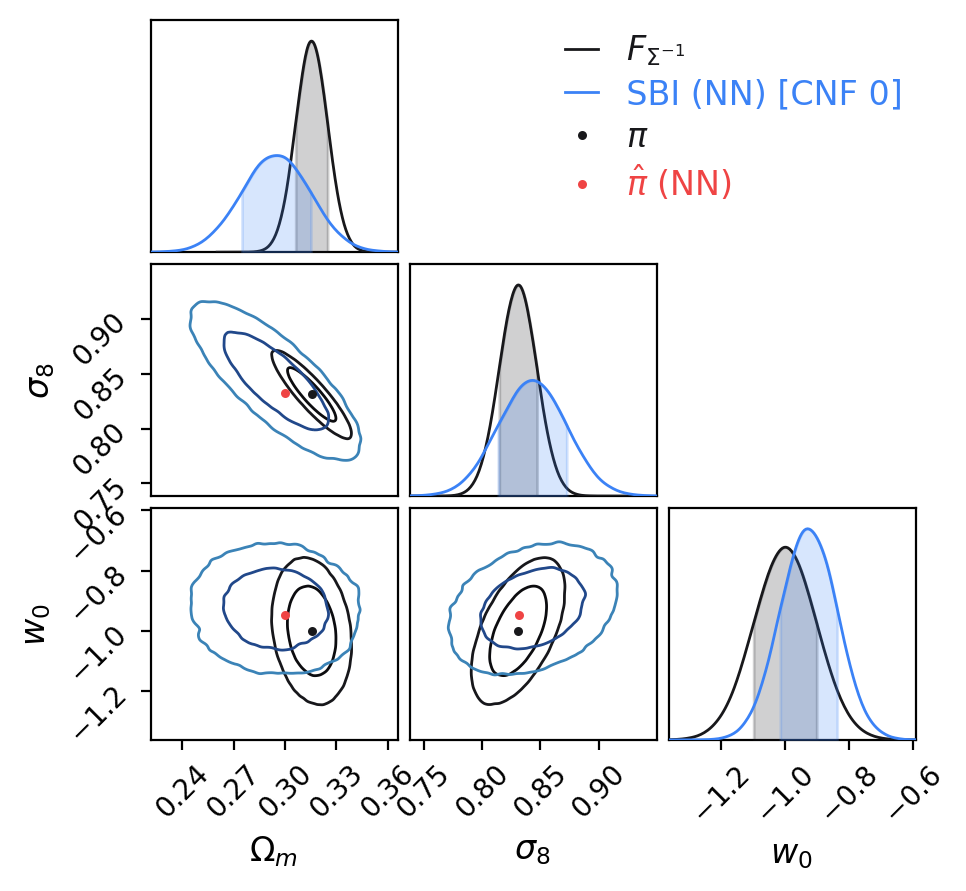

In [16]:
c = ChainConsumer()

c.add_chain(
    Chain.from_covariance(
        alpha,
        Finv,
        columns=parameter_names,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        shade_alpha=0.
    )
)

for i, posterior in enumerate(posteriors):
    samples, samples_log_prob = posterior
    
    for n in range(n_chains):
        c.add_chain(
            Chain(
                samples=make_df(samples[n], samples_log_prob[n], parameter_names), 
                name="SBI (NN) [{} {}]".format(ensemble.get_nde_names()[i], i), 
                shade_alpha=0.
            )
    )

c.add_marker(
    location=dict(zip(parameter_names, np.asarray(alpha))), name=r"$\pi$", color="k"
)
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(X_))), name=r"$\hat{\pi}$ (NN)", color="r"
)

fig = c.plotter.plot()
fig.set_dpi(200)
fig.set_figheight(4.5)
fig.set_figwidth(4.5)
plt.show()

Have a look at the other examples.